In [51]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
from collections import Counter
from nltk.corpus import stopwords
import nltk
import re
import string
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [53]:
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sangeeta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
# load and inspect the data
df = pd.read_csv("Data.csv")

In [57]:
print(df.head())

                               statement  status
0     Feeling happy and motivated today.  Normal
1  Just relaxed with family over dinner.  Normal
2  I love how peaceful everything feels.  Normal
3     Laughing with friends made my day.  Normal
4   Woke up feeling fresh and energetic.  Normal


In [59]:
print(df.isnull().sum())

statement    0
status       0
dtype: int64


In [61]:
print("Shape:", df.shape)
print("Duplicates:", df.duplicated().sum())

Shape: (238, 2)
Duplicates: 0


In [63]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  238 non-null    object
 1   status     238 non-null    object
dtypes: object(2)
memory usage: 3.8+ KB
None


In [65]:
print(df.describe())

                                 statement      status
count                                  238         238
unique                                 238           5
top     Feeling happy and motivated today.  Depression
freq                                     1          67


In [67]:
# clean column and drop NA
df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # Only if column exists
df = df.dropna(subset=['statement'])  # Drop rows where 'statement' is null
df = df.reset_index(drop=True)

# Visualizations

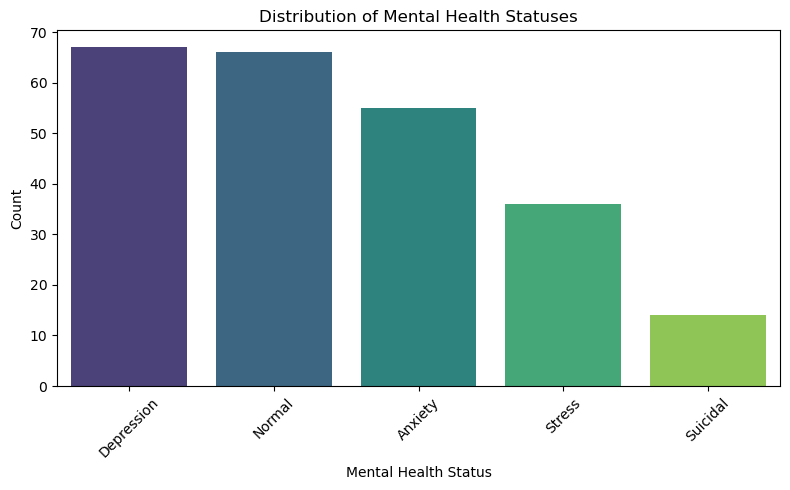

In [70]:
# Distribution of Mental Health Status
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='status', order=df['status'].value_counts().index, palette='viridis')
plt.title("Distribution of Mental Health Statuses")
plt.xlabel("Mental Health Status")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

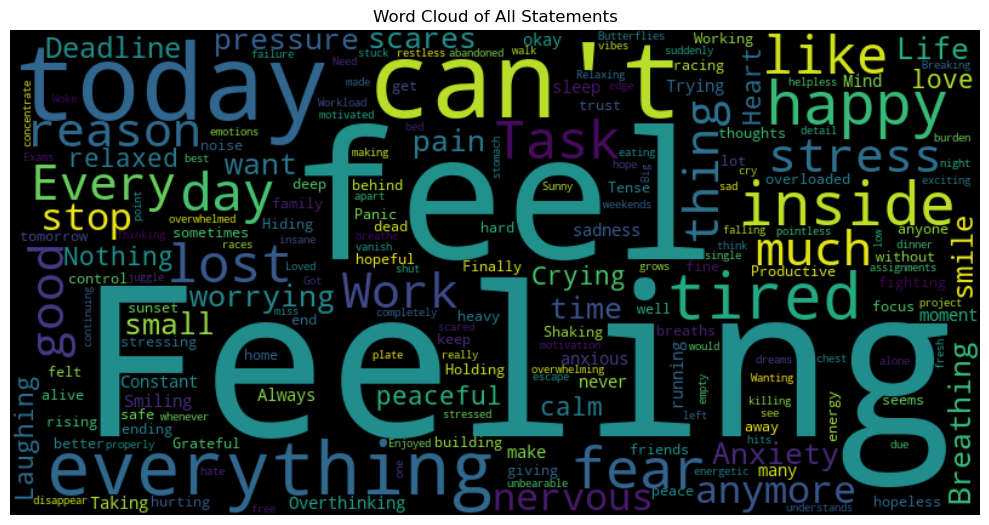

In [72]:
# Word Cloud
all_text = " ".join(df['statement'].astype(str))
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color="black", 
                      colormap="viridis", stopwords=set(stopwords.words('english'))).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud of All Statements")
plt.axis("off")
plt.tight_layout()
plt.show()

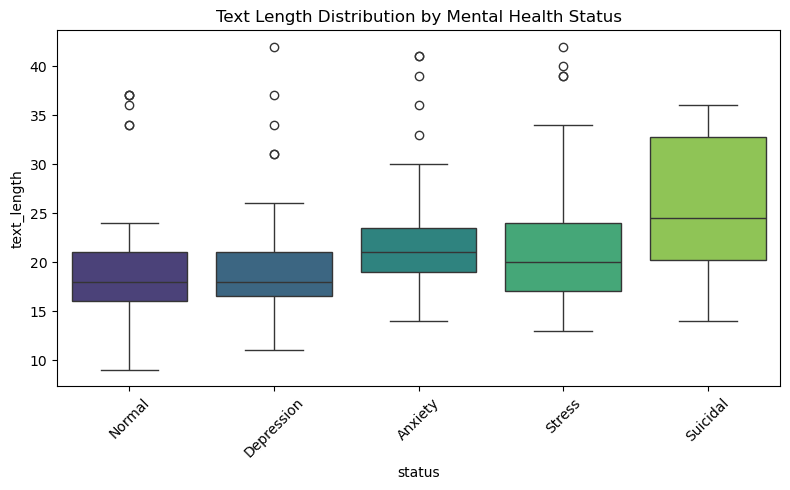

In [74]:
# Text Length Analysis
df['text_length'] = df['statement'].apply(len)
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='status', y='text_length', palette='viridis')
plt.title("Text Length Distribution by Mental Health Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

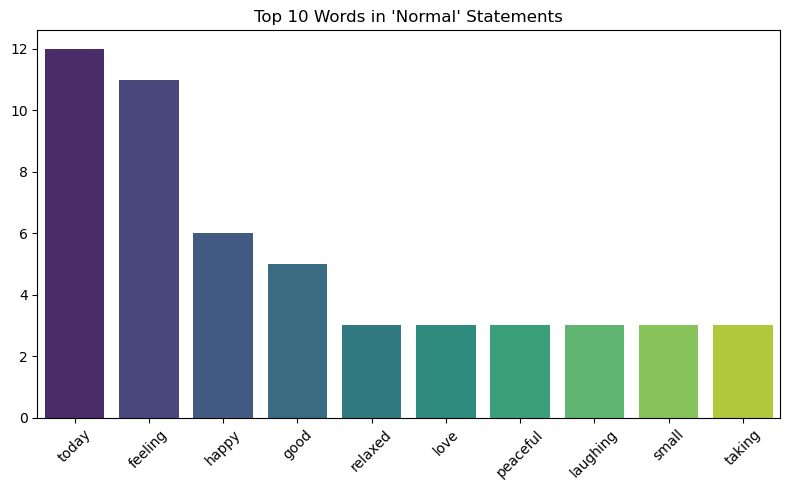

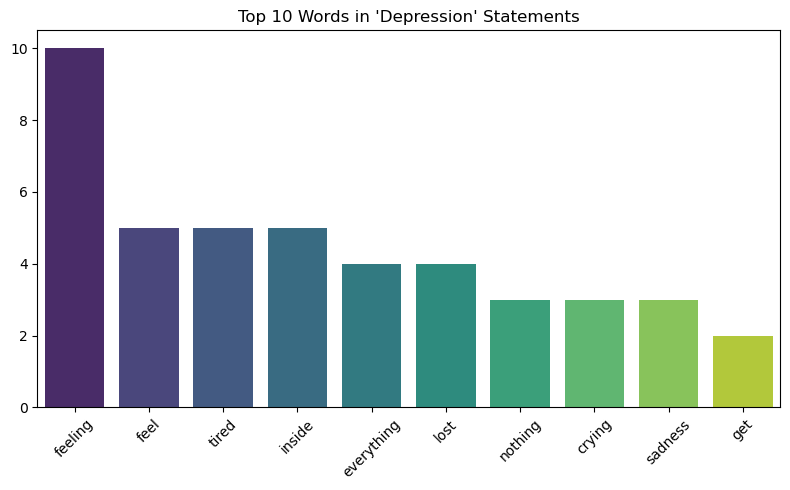

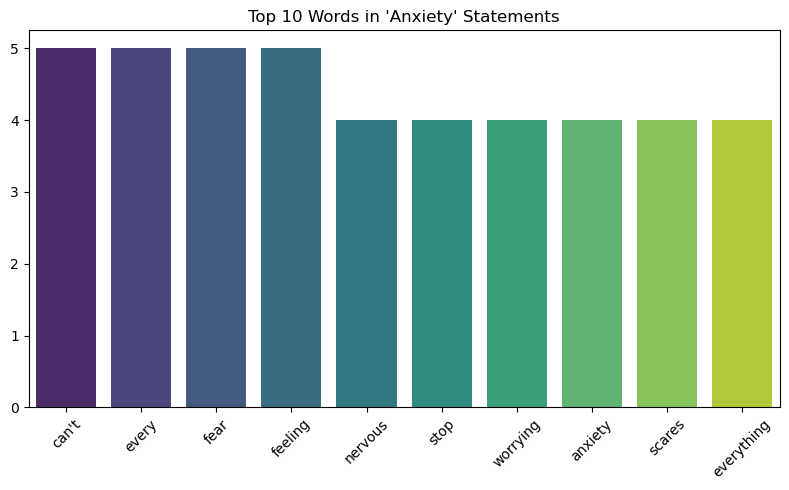

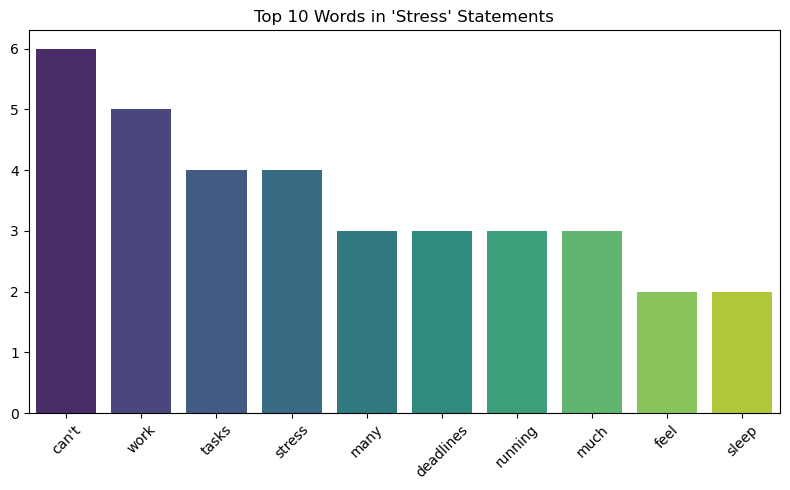

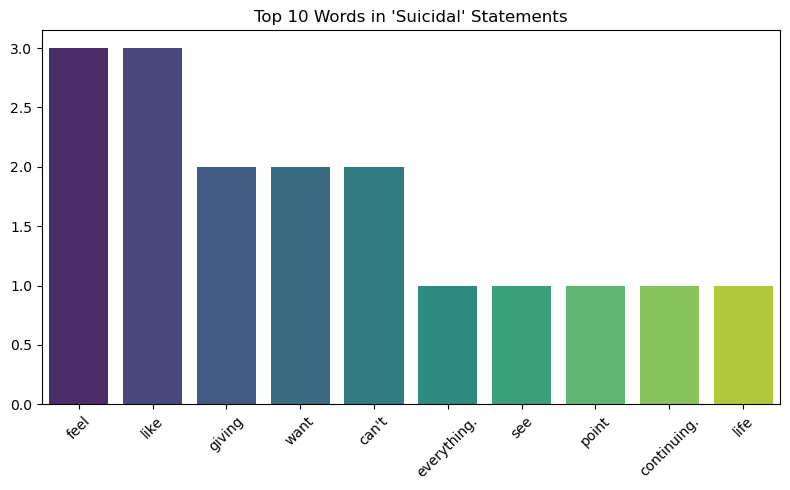

In [76]:
# Most Common Words Per Status
def most_common_words(text):
    words = text.lower().split()
    words = [word for word in words if word not in stopwords.words('english')]
    return Counter(words).most_common(10)

for status in df['status'].unique():
    status_text = " ".join(df[df['status'] == status]['statement'].astype(str))
    common_words = most_common_words(status_text)
    
    if common_words:  # Ensure it's not empty
        words, counts = zip(*common_words)
        plt.figure(figsize=(8, 5))
        sns.barplot(x=list(words), y=list(counts), palette='viridis')
        plt.title(f"Top 10 Words in '{status}' Statements")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [78]:
# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text.strip()

df['statement'] = df['statement'].apply(clean_text)


In [80]:
# label encoding
label_encoder = LabelEncoder()
df['status'] = label_encoder.fit_transform(df['status'])  # Save original labels


In [82]:
#  TF-IDF + Train-Test Split
X = df['statement']
y = df['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [84]:
#Train & Evaluate Model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [86]:
y_pred_train = model.predict(X_train_tfidf)
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, target_names=label_encoder.classes_))

Training Accuracy: 0.9
              precision    recall  f1-score   support

     Anxiety       0.98      0.96      0.97        45
  Depression       0.78      1.00      0.88        53
      Normal       0.94      0.98      0.96        52
      Stress       1.00      0.80      0.89        30
    Suicidal       0.00      0.00      0.00        10

    accuracy                           0.90       190
   macro avg       0.74      0.75      0.74       190
weighted avg       0.87      0.90      0.88       190



In [88]:
y_pred = model.predict(X_test_tfidf)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.5416666666666666


In [90]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

     Anxiety       0.71      0.50      0.59        10
  Depression       0.38      0.57      0.46        14
      Normal       0.59      0.71      0.65        14
      Stress       1.00      0.50      0.67         6
    Suicidal       0.00      0.00      0.00         4

    accuracy                           0.54        48
   macro avg       0.54      0.46      0.47        48
weighted avg       0.56      0.54      0.53        48



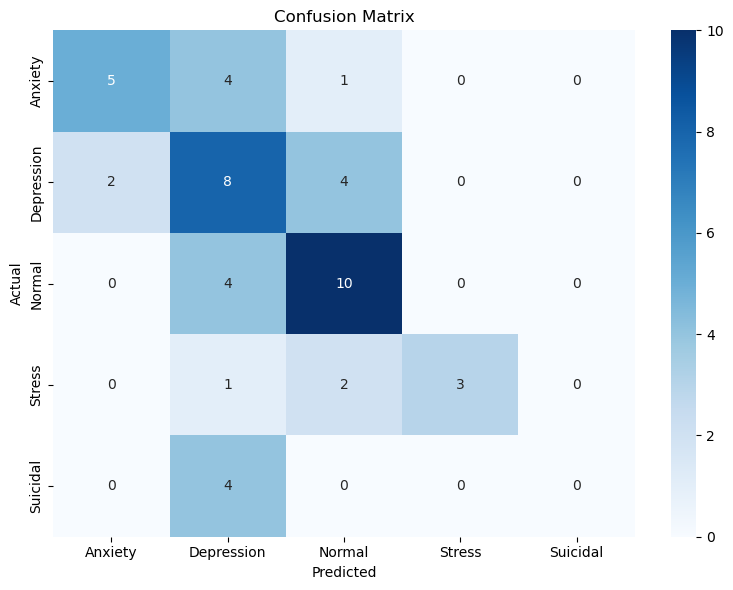

In [92]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [94]:
# Save Model and Vectorizer
with open("mental_health_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [96]:
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [98]:
# Predict & Recommend
loaded_model = pickle.load(open("mental_health_model.pkl", "rb"))
loaded_tfidf = pickle.load(open("tfidf_vectorizer.pkl", "rb"))

In [100]:
sample = input("Enter Your Caption: ")
sample_clean = clean_text(sample)
sample_tfidf = loaded_tfidf.transform([sample_clean])
prediction = loaded_model.predict(sample_tfidf)
predicted_status = label_encoder.inverse_transform(prediction)[0]
print("Predicted Status:", predicted_status)

Enter Your Caption:  i am so happy


Predicted Status: Normal


In [102]:
def provide_recommendation(label):
    recommendations = {
        "Normal": "You seem to be in a balanced state. Keep practicing healthy routines and mindfulness.",
        "Depression": "You might be feeling low. Please talk to someone you trust or consider professional support.",
        "Anxiety": "If you’re feeling anxious, try breathing exercises or meditation. Seek help if it persists.",
        "Suicidal": "Your message is deeply concerning. Please seek immediate help from a mental health professional or a helpline.",
        "Personality disorder": "It may help to explore therapy options tailored to your personality experiences.",
        "Other": "Consider monitoring your mental state and journaling your thoughts. If discomfort grows, seek help."
    }
    return recommendations.get(label, "We're here for you. Consider reaching out for support when needed.")

print("Recommendation:", provide_recommendation(predicted_status))


Recommendation: You seem to be in a balanced state. Keep practicing healthy routines and mindfulness.


In [104]:
pickle.dump(label_encoder, open("label_encoder.pkl", "wb"))
